# Robots.txt On Top-K Sites

See the [data preparation notebook](./data-preparation-top-k-sample.ipynb) for data collection.



In [1]:
import math
import io
import json
import logging
import os
import re

from collections import Counter, defaultdict
from isoweek import Week

import zstandard

try:
    import ujson as json
except ImportError:
    import json

import pandas as pd
pd.options.mode.copy_on_write = True

# logging (for progress and times)
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s %(message)s', level=logging.INFO)

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns
sns.set_theme(style='whitegrid')

from matplotlib.colors import ListedColormap
my_color_map = ListedColormap(sns.color_palette('pastel').as_hex())


## Read Top-K Sites and Robots.txt Captures



In [2]:
df_crawls = pd.read_csv('../../data/top-k-sample/crawls.txt', names=['crawl'])

# selection on few crawls for development
#crawls = ['CC-MAIN-2016-36', 'CC-MAIN-2022-33', 'CC-MAIN-2025-08']
crawls = df_crawls['crawl'].tolist()

df_ranks = pd.read_csv('../../data/top-k-sites/tranco/tranco_combined.txt.gz',
                       sep='\t', names=['rank', 'site'])
df_ranks.set_index('site', inplace=True)
ranks_max = max(df_ranks['rank'])

# top-k samples
top_k_list = [('1k', 1_000), ('10k', 10_000), ('50k', 50_000),
              ('100k', 100_000), ('1M', 1_000_000), ('2M', ranks_max)]

df_captures = pd.read_parquet('../../data/top-k-sample/captures/',
                              filters=[('crawl', 'in', crawls)])

df_captures.head()

,host,domain,rank,url,fetch_status,fetch_redirect,content_mime_type,content_mime_detected,robotstxt_fetch_status,is_robotstxt_mime_type,crawl
0,genesisowners.com,genesisowners.com,929742,http://genesisowners.com/robots.txt,200,None,text/plain,None,success,True,CC-MAIN-2016-36
1,historyhouse.com,historyhouse.com,1693115,http://historyhouse.com/robots.txt,200,None,text/plain,None,success,True,CC-MAIN-2016-36
2,oopweb.com,oopweb.com,1857697,http://oopweb.com/robots.txt,404,None,text/html,None,notfound,False,CC-MAIN-2016-36
3,dbrs.com,dbrs.com,985809,http://dbrs.com/robots.txt,200,None,text/plain,None,success,True,CC-MAIN-2016-36
4,sonybank.net,sonybank.net,1091104,http://sonybank.net/robots.txt,404,None,text/html,None,notfound,False,CC-MAIN-2016-36


In [3]:
df_captures['crawl'].value_counts(sort=False)

crawl
CC-MAIN-2016-36     604440
CC-MAIN-2017-09     717829
CC-MAIN-2017-34     615175
CC-MAIN-2018-09     807732
CC-MAIN-2018-34     980026
CC-MAIN-2019-09    1033590
CC-MAIN-2019-35     864256
CC-MAIN-2020-05    1150740
CC-MAIN-2020-10    1224823
CC-MAIN-2020-16    1205770
CC-MAIN-2020-24    1232393
CC-MAIN-2020-29    1268906
CC-MAIN-2020-34    1302985
CC-MAIN-2020-40    1289941
CC-MAIN-2020-45    1299763
CC-MAIN-2020-50    1283099
CC-MAIN-2021-04    1323643
CC-MAIN-2021-10    1307569
CC-MAIN-2021-17    1272138
CC-MAIN-2021-21    1320776
CC-MAIN-2021-25    1302746
CC-MAIN-2021-31    1222270
CC-MAIN-2021-39    1325971
CC-MAIN-2021-43    1281816
CC-MAIN-2021-49    1349092
CC-MAIN-2022-05    1264572
CC-MAIN-2022-21    1336149
CC-MAIN-2022-27    1345647
CC-MAIN-2022-33    1358966
CC-MAIN-2022-40    1267845
CC-MAIN-2022-49    1381430
CC-MAIN-2023-06    1268809
CC-MAIN-2023-14    1254345
CC-MAIN-2023-23    1295431
CC-MAIN-2023-40    1334486
CC-MAIN-2023-50    1508279
CC-MAIN-2024-10    152

In [4]:
logging.info('Reading robots.txt directives counts')
# counts of robots.txt directives extracted from robots.txt WARC records
# - 1.6 GiB tab-separated text, ZStandard compressed
# - (for now) read only what we need:
#   - user-agent counts

# read Hive partitioned CSV files into a Pandas DataFrame
useragents = dict()
#dfs = list()
for crawl in crawls:
    d = pd.read_csv(os.path.join('../../data/top-k-sample/counts/',
                                 'crawl=' + crawl,
                                 crawl + '.txt.zst'),
                    sep='\t',
                    header=0,
                    names=['directive', 'value', 'cnt'])
    #d['crawl'] = crawl
    #dfs.append(d)

    agents = Counter()
    for _, row in d[d['directive'] == 'user-agent'].iterrows():
        if row['value'] and type(row['value']) == str:
            agents[row['value'].lower()] += row['cnt']
    
    for ua in agents:
        if ua not in useragents:
            useragents[ua] = [agents[ua], 1]
        else:
            useragents[ua][0] += agents[ua]
            useragents[ua][1] += 1

# concatenate DataFrames
#df_counts = pd.concat(dfs)
#df_counts['year'] = df_counts['crawl'].str[8:12]
#del dfs

#df_counts.head()
#df_counts[df_counts['directive'] == 'user-agent'][['crawl', 'value', 'cnt']].head()

2025-10-18 20:56:30,972 INFO Reading robots.txt directives counts


In [5]:
# Store user-agent names and counts in a DataFrame
#
# but keep only frequent user-agents
# - appearing, at least, in 5 crawls
#   (or all crawls for a smaller test set)
useragents_min_crawl = min(5, len(crawls))
# - appearing, at least, 250 times in total over all crawls
useragents_min_count = 250
# - skip overlong user-agent names
useragents_max_length = 32
# - except a user-agent name follows the user-agent token specification of RFC 9309
#   note: we cannot enforce it, because even frequent user-agent names
#         such as "MJ12bot" do not follow RFC 9309
user_agent_pattern = re.compile(r'[a-zA-Z_-]+|\*')
useragents_frequent = dict(
    filter(lambda it: it[1][1] >= useragents_min_crawl
           and it[1][0] >= useragents_min_count
           and (len(it[0]) <= useragents_max_length
                or user_agent_pattern.fullmatch(it[0])),
           useragents.items())
)

df_useragents = pd.DataFrame.from_dict(useragents_frequent, orient='index',
                                       columns=['cnt', 'n_crawls']
                                      ).sort_values(['n_crawls', 'cnt'], ascending=False)
df_useragents.to_csv('../../data/top-k-sample/user-agents-frequent.csv',
                     header=True, index=True)
useragents_frequent = useragents_frequent.keys()
#del useragents
logging.info('Number of "frequent" user-agents: %d', len(useragents_frequent))

df_useragents.head()

2025-10-18 20:59:04,910 INFO Number of "frequent" user-agents: 6807


,cnt,n_crawls
*,34009868,55
googlebot,1991408,55
ahrefsbot,1880177,55
mj12bot,1847980,55
yandex,1359381,55


In [6]:
# most freqent user-agent names, appearing in 10 or less crawls
df_useragents[df_useragents['n_crawls'] <= 10].sort_values(['cnt'], ascending=False).head()

,cnt,n_crawls
perplexity-user,7923,8
cohere-training-data-crawler,7777,10
claude-user,5268,6
claude-searchbot,4746,6
qualifiedbot,4444,9


In [7]:
logging.info('Reading robots.txt rulesets')
# - 1.7 GiB ZStandard compressed JSON
# - classify rulesets, but do not save the entire set of rules

robotstxt_ruleset_classes = ['disallow-all', 'allow-all', 'allow-part']

def classify_robotstxt_rules(rules):
    # allow-all, disallow-all, allow-part
    if rules == {'disallow': ['/']}:
        return 'disallow-all'
    if (rules == {'allow': ['/']} or rules == {'allow': ['*']}
        or rules == {'allow': ['/*']} or rules == {'allow': ['']}
        or rules == {'disallow': ['']}):
        return 'allow-all'
    return 'allow-part'


#rulesets = defaultdict(lambda: defaultdict(list))
ruleset_classes = defaultdict(lambda: defaultdict(dict))
for crawl in crawls:
    with open('../../data/top-k-sample/rulesets/{}-rulesets.jsonl.zst'.format(crawl), 'rb') as fh:
        dctx = zstandard.ZstdDecompressor()
        stream_reader = dctx.stream_reader(fh)
        text_stream = io.TextIOWrapper(stream_reader, encoding='utf-8')
        for line in text_stream:
            obj = json.loads(line)
            for url in obj:
                #rulesets[crawl][url] = obj[url]
                for ua, rules in obj[url].items():
                    if ua.lower() not in useragents_frequent:
                        # skip less frequent user-agents
                        continue
                    ruleset_classes[crawl][url][ua] = classify_robotstxt_rules(rules)

#df_rulesets = pd.DataFrame(rulesets).reset_index(names='url').melt(
#    id_vars=['url'], var_name='crawl', value_name='rulesets')
#del rulesets
#df_rulesets.head()

df_ruleset_classes = pd.DataFrame(ruleset_classes).reset_index(names='url').melt(
        id_vars=['url'], var_name='crawl', value_name='ruleset_classes')
del ruleset_classes
df_ruleset_classes.head()

2025-10-18 20:59:04,924 INFO Reading robots.txt rulesets


,url,crawl,ruleset_classes
0,http://heartcc.com/robots.txt,CC-MAIN-2016-36,"{'*': 'allow-part', 'IRLbot': 'disallow-all', ..."
1,http://gaz-service.ru/robots.txt,CC-MAIN-2016-36,{'*': 'allow-part'}
2,http://clippersstore.com/robots.txt,CC-MAIN-2016-36,"{'*': 'allow-part', 'Nutch': 'disallow-all', '..."
3,http://al-hor.com/robots.txt,CC-MAIN-2016-36,"{'*': 'disallow-all', 'Baiduspider': 'allow-pa..."
4,http://www.kika.de/robots.txt,CC-MAIN-2016-36,{'*': 'allow-part'}


In [8]:
# merge ruleset classes column into captures dataframe

df_captures = df_captures.merge(df_ruleset_classes, how='left', on=['crawl', 'url'])
df_captures['robotstxt_parsed'] = df_captures['ruleset_classes'].map(
    lambda c: not math.isnan(c)
    if isinstance(c, float)
    else len(c) > 0)
df_captures.head()

,host,domain,rank,url,fetch_status,fetch_redirect,content_mime_type,content_mime_detected,robotstxt_fetch_status,is_robotstxt_mime_type,crawl,ruleset_classes,robotstxt_parsed
0,genesisowners.com,genesisowners.com,929742,http://genesisowners.com/robots.txt,200,None,text/plain,None,success,True,CC-MAIN-2016-36,"{'*': 'allow-part', 'Fasterfox': 'disallow-all...",True
1,historyhouse.com,historyhouse.com,1693115,http://historyhouse.com/robots.txt,200,None,text/plain,None,success,True,CC-MAIN-2016-36,"{'*': 'allow-all', 'AhrefsBot': 'disallow-all'...",True
2,oopweb.com,oopweb.com,1857697,http://oopweb.com/robots.txt,404,None,text/html,None,notfound,False,CC-MAIN-2016-36,NaN,False
3,dbrs.com,dbrs.com,985809,http://dbrs.com/robots.txt,200,None,text/plain,None,success,True,CC-MAIN-2016-36,"{'80legs.com': 'disallow-all', 'AhrefsBot': 'd...",True
4,sonybank.net,sonybank.net,1091104,http://sonybank.net/robots.txt,404,None,text/html,None,notfound,False,CC-MAIN-2016-36,NaN,False


## Usage of Robots.txt on Top-K Sites

In [9]:
# crawl -> <nothing, notfound, forbidden,
#           defer_visits, success, is_robotstxt>
# stratified samples

# Note: there may be multiple robots.txt URLs per host.
# RFC 9309 defines the robots.txt URL as
#   "scheme:[//authority]/robots.txt"
# So, there might be, e.g.
#   http://example.com/robots.txt
#   https://example.com/robots.txt
#   http://example.com:8080/robots.txt
#
# We select here the most reliable variant. That is a successful fetch
# is given precedence over an unsuccessful fetch. And any capture is
# used whether it's http://, https:// or with a specific port.
def robotstxt_status_counts(df, crawl, top_k):
    d = df[(df['crawl'] == crawl) & (df['rank'] <= top_k)]
    hosts_fetch_success = set(d[d['robotstxt_fetch_status']
                                  == 'success']['host'].unique().tolist())
    hosts_http_allow_all = set(
        d[d['robotstxt_fetch_status'].isin(
            ['notfound', 'other', 'unauthorized']
        )]['host'].unique()).difference(hosts_fetch_success)
    hosts_http_forbidden = set(d[d['robotstxt_fetch_status']
                                  == 'forbidden']['host'].unique().tolist())
    hosts_http_forbidden = hosts_http_forbidden \
        .difference(hosts_fetch_success) \
        .difference(hosts_http_allow_all)
    hosts_http_defer_visits = set(d[d['robotstxt_fetch_status']
                                      == 'defer_visits']['host'].unique().tolist())
    hosts_http_defer_visits = hosts_http_defer_visits \
        .difference(hosts_fetch_success) \
        .difference(hosts_http_allow_all) \
        .difference(hosts_http_forbidden)
    # redirects not resolved or not resolvable given the index data
    hosts_redirect_not_resolved = set(d[d['robotstxt_fetch_status']
                                      == 'redirect']['host'].unique().tolist())
    hosts_redirect_not_resolved = hosts_redirect_not_resolved \
        .difference(hosts_http_forbidden) \
        .difference(hosts_http_defer_visits) \
        .difference(hosts_fetch_success) \
        .difference(hosts_http_allow_all) \
        .difference(hosts_http_forbidden)
    hosts_has_robotstxt = set(d[(d['robotstxt_fetch_status'] == 'success')
                                & d['is_robotstxt_mime_type']]['host'].unique().tolist())
    hosts_robotstxt_parsed = set(d[(d['robotstxt_fetch_status'] == 'success')
                                 & d['is_robotstxt_mime_type']
                                 & d['robotstxt_parsed']]['host'].unique().tolist())
    res = dict()
    res['No robots.txt capture'] = top_k - len(d['rank'].unique())
    res['HTTP forbidden'] = len(hosts_http_forbidden)
    res['HTTP defer visits'] = len(hosts_http_defer_visits)
    res['HTTP allow all'] = len(hosts_http_allow_all)
    res['HTTP redirect not resolved'] = len(hosts_redirect_not_resolved)
    res['MIME not a robots.txt'] = \
        len(hosts_fetch_success) - len(hosts_has_robotstxt)
    res['Robots.txt no rules'] = len(hosts_has_robotstxt) - len(hosts_robotstxt_parsed)
    res['Robots.txt with rules'] = len(hosts_robotstxt_parsed)
    # Note: except for older crawls only robots.txt captures, where the MIME
    #       type fits a robots.txt, are archived. Consequently,
    #       'fetch_success_not_a_robotstxt' can be zero.
    assert(top_k == sum(res.values()))
    return res

#robotstxt_status_counts(df, 'CC-MAIN-2025-08', ranks_max)
robotstxt_status_counts(df_captures, 'CC-MAIN-2022-33', 20)

{'No robots.txt capture': 6,
 'HTTP forbidden': 0,
 'HTTP defer visits': 0,
 'HTTP allow all': 1,
 'HTTP redirect not resolved': 4,
 'MIME not a robots.txt': 0,
 'Robots.txt no rules': 0,
 'Robots.txt with rules': 9}

In [10]:
# test: commoncrawl.org has a valid robots.txt
robotstxt_status_counts(df_captures[df_captures['host'] == 'commoncrawl.org'],
                        'CC-MAIN-2022-33', ranks_max)

{'No robots.txt capture': 2042065,
 'HTTP forbidden': 0,
 'HTTP defer visits': 0,
 'HTTP allow all': 0,
 'HTTP redirect not resolved': 0,
 'MIME not a robots.txt': 0,
 'Robots.txt no rules': 0,
 'Robots.txt with rules': 1}

In [11]:
logging.info('Status counts of robots.txt captures')

@staticmethod
def date_of(crawl):
    [_, _, year, week] = crawl.split('-')
    return Week(int(year), int(week)).monday()

status_counts = dict()
for top, k in top_k_list:
    logging.info('Status counts at %s', top)
    for crawl in crawls:
        status_counts[crawl,top] = robotstxt_status_counts(df_captures, crawl, k)
status_counts = pd.DataFrame(status_counts).transpose().reset_index(names=['crawl', 'top-k'])
status_counts['dt'] = status_counts['crawl'].apply(lambda c: date_of(c))
status_counts.to_csv('../../data/top-k-sample/robotstxt-status-counts-topk.csv',
                     header=True, index=False)
status_counts

2025-10-18 21:05:34,855 INFO Status counts of robots.txt captures
2025-10-18 21:05:34,860 INFO Status counts at 1k
2025-10-18 21:08:26,971 INFO Status counts at 10k
2025-10-18 21:11:20,547 INFO Status counts at 50k
2025-10-18 21:14:16,493 INFO Status counts at 100k
2025-10-18 21:17:15,390 INFO Status counts at 1M
2025-10-18 21:21:10,800 INFO Status counts at 2M


,crawl,top-k,No robots.txt capture,HTTP forbidden,HTTP defer visits,HTTP allow all,HTTP redirect not resolved,MIME not a robots.txt,Robots.txt no rules,Robots.txt with rules,dt
0,CC-MAIN-2016-36,1k,444,8,1,49,171,14,12,301,2016-09-05
1,CC-MAIN-2017-09,1k,332,11,2,56,193,20,17,369,2017-02-27
2,CC-MAIN-2017-34,1k,351,7,0,50,376,8,8,200,2017-08-21
3,CC-MAIN-2018-09,1k,344,8,3,50,375,11,6,203,2018-02-26
4,CC-MAIN-2018-34,1k,316,8,2,61,389,11,7,206,2018-08-20
...,...,...,...,...,...,...,...,...,...,...,...
325,CC-MAIN-2025-21,2M,1130544,40287,32343,149580,45815,0,40662,602835,2025-05-19
326,CC-MAIN-2025-26,2M,1147304,40775,33318,142409,46142,0,40592,591526,2025-06-23
327,CC-MAIN-2025-30,2M,1152320,43074,32234,139623,45147,0,40350,589318,2025-07-21
328,CC-MAIN-2025-33,2M,1155791,44096,29172,137193,44948,0,40435,590431,2025-08-11


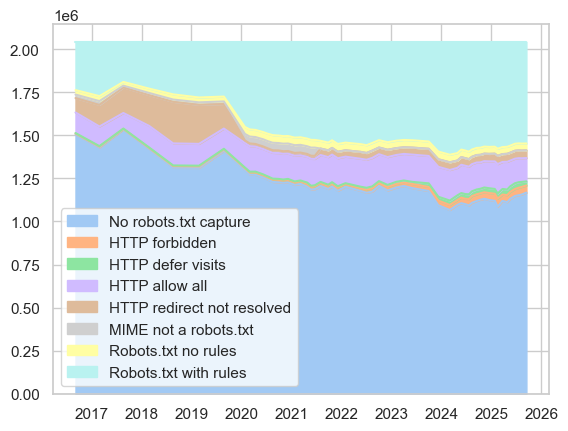

In [12]:
#status_counts = pd.read_csv('../../data/top-k-sample/robotstxt-status-counts-topk.csv')
ax = status_counts[status_counts['top-k'] == '2M'].plot(
        x='dt', kind='area', stacked=True, cmap=my_color_map)
# axes.legend(fontsize=7)
ax.xaxis.set_label_text('')
ax.get_figure().savefig('img/robotstxt-status-counts.pdf')

<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

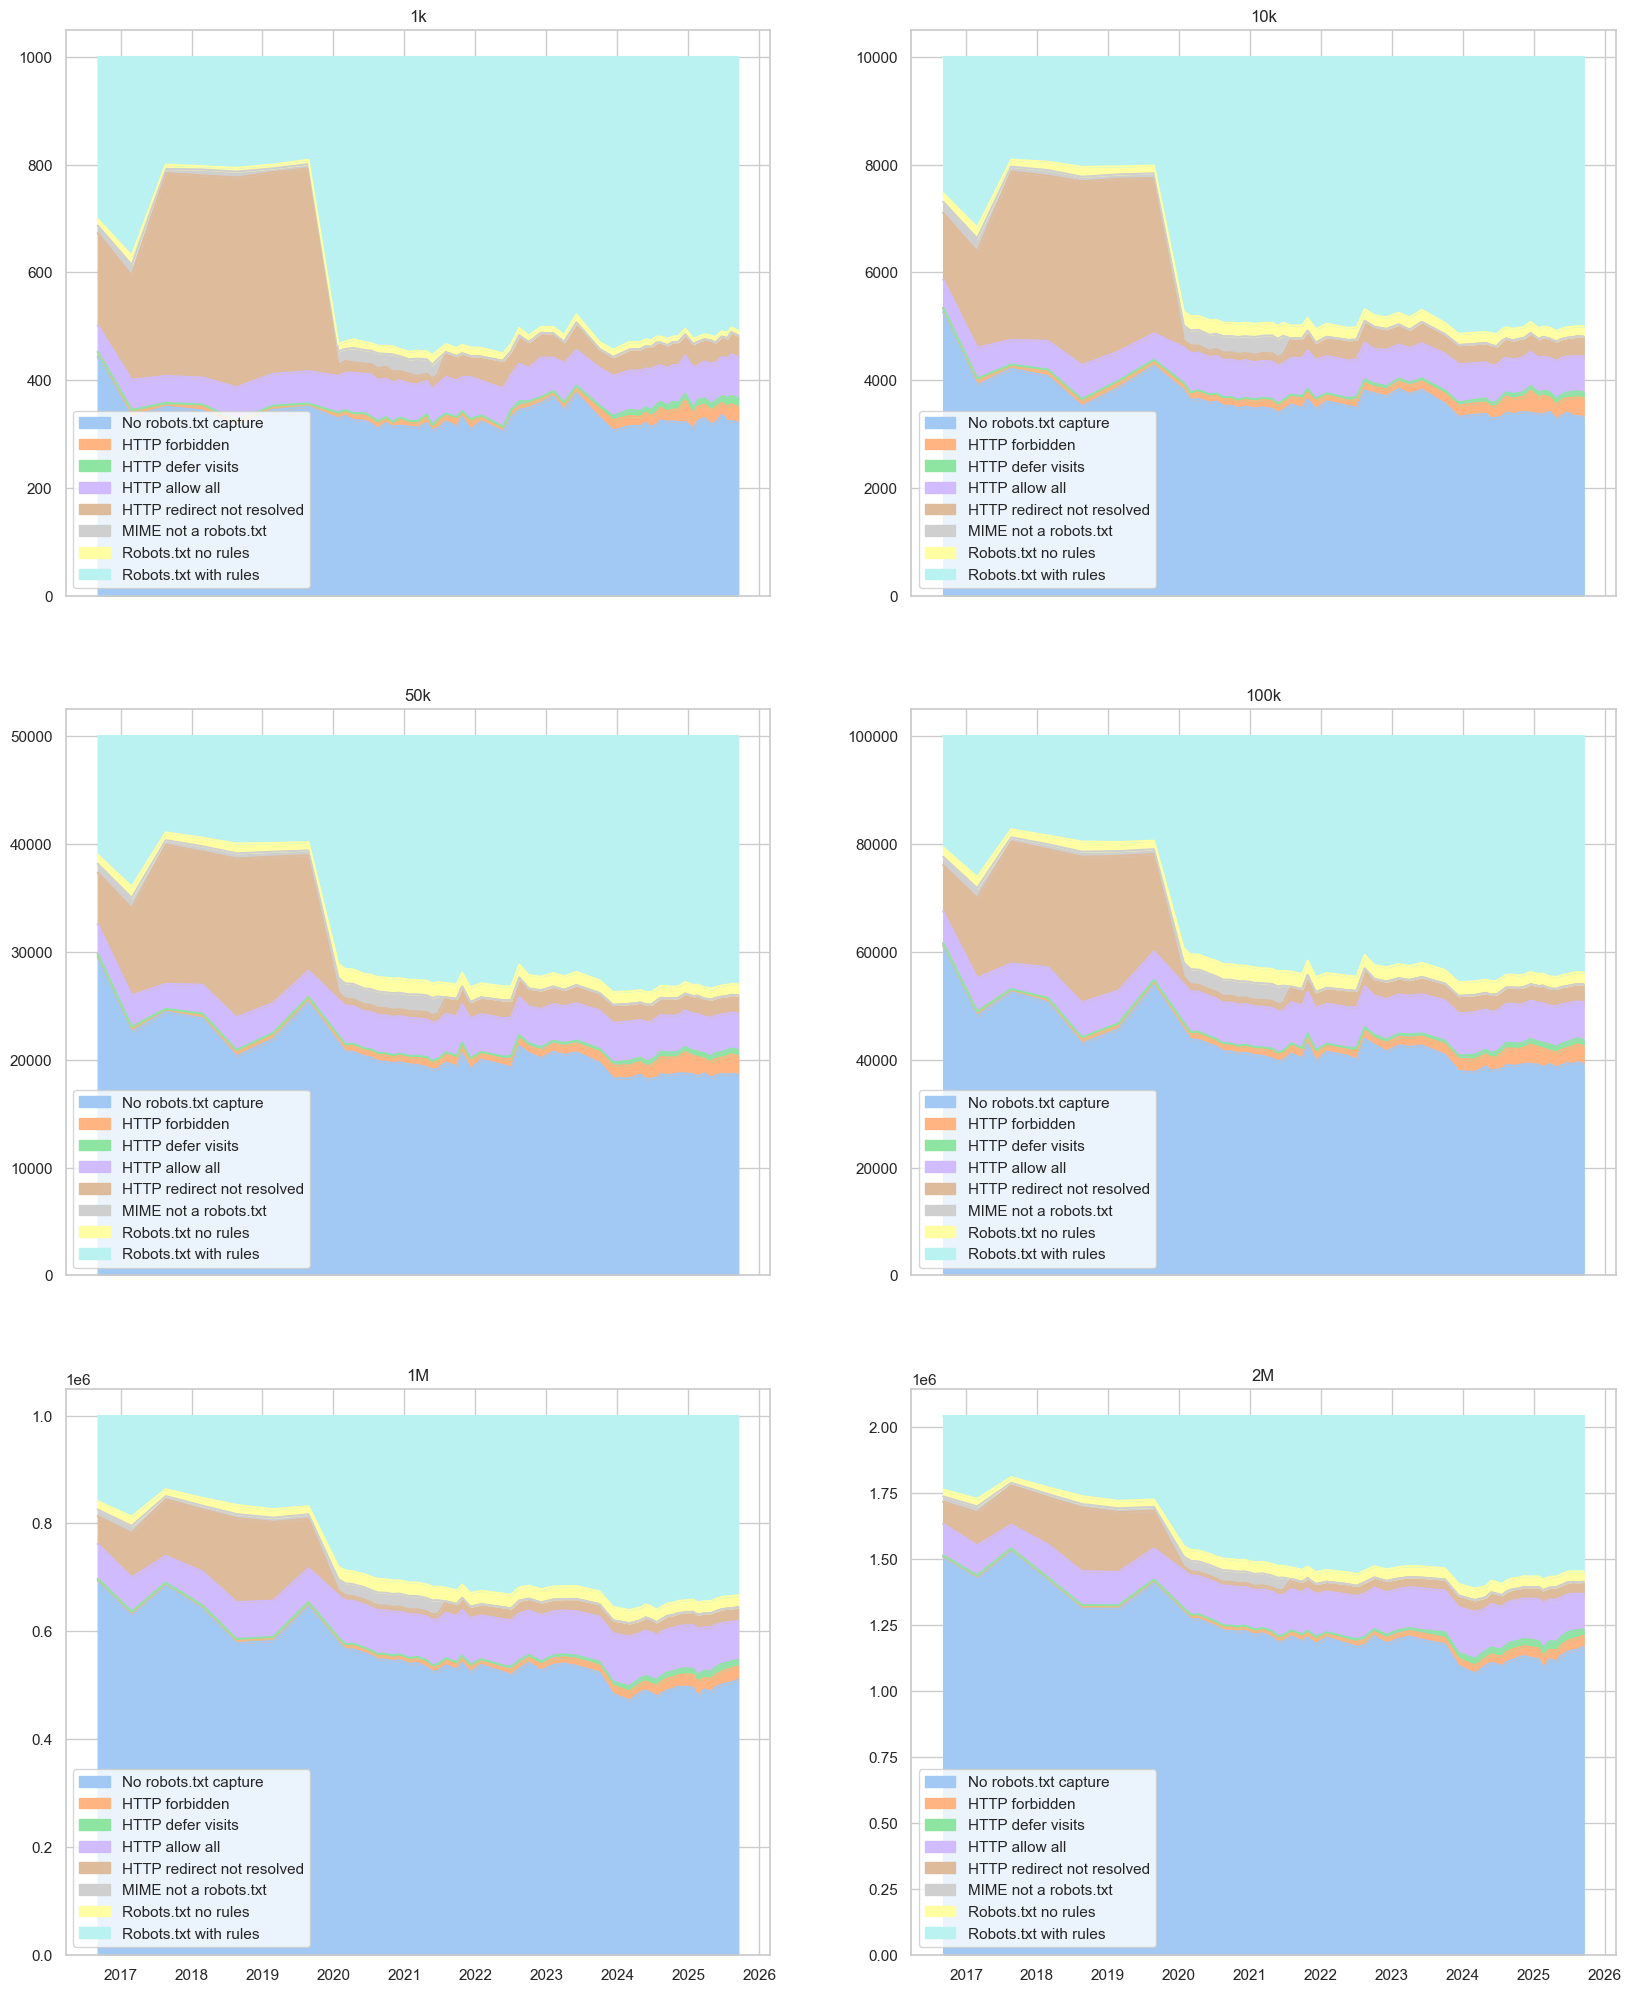

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=False,
                         squeeze=False, figsize=[20,25])

n = 0
for top_k, _ in top_k_list:
    plot = status_counts[status_counts['top-k'] == top_k].plot(
        x='dt',
        kind='area',
        stacked=True,
        ax=axes[int(n/2),n%2],
        title=top_k,
        cmap=my_color_map)
    plot.xaxis.set_label_text('')
    n += 1
plt.savefig('img/robotstxt-status-counts-topk.pdf')
plt

- more robots.txt capture are missing
  - for years before 2020 (but that's expected because the domain list is from 2020 - 2024)
  - following redirects is mandatory
    - but note that the crawler followed robots.txt redirects even before 2016 - 2019, however, redirects weren't not recorded in the URL index
  - for lower ranking sites. That is the availability of the robots.txt file depends on the importance of a site. However, it's unclear whether
    - lower ranking sites may have not be visited by the crawler
    - or do not provide a robots.txt file
- recently more sites signal that they do not want to be crawled via HTTP status codes. But these might be also anti-bot measures which cover all URLs of a site including the robots.txt

## User-Agents Addressed



In [16]:
# The user-agent counts extracted above do not take into account
# - that there may be multiple robots.txt captures per site,
#   e.g. http:// and https:// variants
# - and the total counts do not allow for stratified metrics over top-k sites
#
# Here, we iterate over all captures and aggregate top-k metrics

user_agent_counts = list()
user_agent_counts_year = list()

# debug: TODO
#ranks_max = max(df_ranks['rank'])
#ranks_max = 50000
#top_k_list = [('1k', 1_000), ('10k', 10_000), ('50k', 50_000),
#              ('100k', 100_000), ('1M', 1_000_000), ('2M', ranks_max)]
#top_k_list = [('1k', 1000), ('2k', 2000), ('5k', ranks_max)]
#top_k_list = [('1k', 1_000), ('10k', 10_000), ('50k', 50_000)]
#crawls = ['CC-MAIN-2016-36', 'CC-MAIN-2022-33', 'CC-MAIN-2025-08']

def get_top_k(rank):
    top = None
    for t, k in reversed(top_k_list):
        if rank > k:
            return top
        else:
            top = t
    return top

current_year = None
hosts_current_year = defaultdict(lambda: defaultdict(set))
for crawl in crawls:
    year = int(crawl[8:12])
    if year != current_year:
        if current_year:
            logging.info('Counting user-agents: aggregating counts (year: %s)',
                         current_year)
            ua_host_counts = Counter()
            ua_seen = set()
            for top, k in top_k_list:
                ua_seen.update(hosts_current_year[top].keys())
                for ua in ua_seen:
                    hosts = hosts_current_year[top][ua]
                    ua_host_counts[ua] += len(hosts)
                    cnt = ua_host_counts[ua]
                    user_agent_counts_year.append(
                        [current_year, top, ua, cnt, 100.0 * cnt / k])
        current_year = year

    logging.info('Counting user-agents: %s', crawl)
    ua_hosts = defaultdict(lambda: defaultdict(set))
    ua_rules = defaultdict(lambda: defaultdict(lambda: defaultdict(set)))
    d = df_captures[df_captures['crawl'] == crawl]
    for _idx, row in d.iterrows():
        if _idx > 0 and (_idx % 250000) == 0:
            logging.info('Counting user-agents: row %i', _idx)
        rank = row['rank']
        if rank > ranks_max:
            continue # debug
        if not row['robotstxt_parsed']:
            continue
        host = row['host']
        for ua, ruleset_class in row['ruleset_classes'].items():
            # lowercase to merge case variants
            ua = ua.lower()
            if ua not in useragents_frequent:
                # skip less frequent user-agents
                continue
            top = get_top_k(rank)
            ua_hosts[top][ua].add(host)
            ua_hosts[top]['(any)'].add(host)
            ua_rules[top][ua][ruleset_class].add(host)
            ua_rules[top]['(any)'][ruleset_class].add(host)
        if '*' not in row['ruleset_classes']:
            # if for one host the wildcard agent wasn't addressed,
            # this means "allow-all" for the wildcard agent
            ua_rules[top][ua]['allow-all'].add(host)

    logging.info('Counting user-agents: aggregating counts')
    ua_host_counts = Counter()
    wildcard_ruleset_classes_counts = defaultdict(Counter)
    ua_ruleset_classes_counts = defaultdict(Counter)
    ua_seen = set()
    for top, k in top_k_list:
        wild_card_rules = dict()
        if '*' in ua_rules[top]:
            # wildcard rules should exist for any sufficiently large top-k sample
            wild_card_rules = ua_rules[top]['*']
        ua_seen.update(ua_hosts[top].keys())
        for ua in ua_seen:
            if ua not in ua_hosts[top]:
                # nothing changed for this top-k stratum,
                # take count from previous one
                cnt = ua_host_counts[ua]
            else:
                hosts = ua_hosts[top][ua]
                ua_host_counts[ua] += len(hosts)
                cnt = ua_host_counts[ua]
                hosts_current_year[top][ua].update(hosts)
            res = [crawl, top, ua, cnt, 100.0 * cnt / k]
            for cl in robotstxt_ruleset_classes:
                ua_ruleset_classes_counts[ua][cl] += len(ua_rules[top][ua][cl])
                res.append(ua_ruleset_classes_counts[ua][cl])
            # counts per user-agent including wildcard rules
            if ua == '*':
                # just copy the values
                for cl in robotstxt_ruleset_classes:
                    wildcard_ruleset_classes_counts[ua][cl] = ua_ruleset_classes_counts[ua][cl]
            elif ua in ua_hosts[top]:
                # if the user-agent is directly addressed,
                # add only the difference set
                non_wildcard_hosts = ua_hosts[top][ua]
                for cl in robotstxt_ruleset_classes:
                    add = len(ua_rules[top][ua][cl])
                    add += len(wild_card_rules[cl].difference(non_wildcard_hosts))
                    wildcard_ruleset_classes_counts[ua][cl] += add
            else:
                for cl in robotstxt_ruleset_classes:
                    wildcard_ruleset_classes_counts[ua][cl] += len(wild_card_rules[cl])
            for cl in robotstxt_ruleset_classes:
                res.append(wildcard_ruleset_classes_counts[ua][cl])
            user_agent_counts.append(res)

if current_year:
    logging.info('Counting user-agents: aggregating counts (year: %s)',
                 current_year)
    # aggregate crawls of the latest year
    ua_host_counts = Counter()
    ua_seen = set()
    for top, k in top_k_list:
        ua_seen.update(hosts_current_year[top].keys())
        for ua in ua_seen:
            hosts = hosts_current_year[top][ua]
            ua_host_counts[ua] += len(hosts)
            cnt = ua_host_counts[ua]
            user_agent_counts_year.append(
                [current_year, top, ua, cnt, 100.0 * cnt / k])

2025-10-18 21:29:44,760 INFO Counting user-agents: CC-MAIN-2016-36
2025-10-18 21:29:53,753 INFO Counting user-agents: row 250000
2025-10-18 21:29:58,444 INFO Counting user-agents: row 500000
2025-10-18 21:30:00,445 INFO Counting user-agents: aggregating counts
2025-10-18 21:30:27,673 INFO Counting user-agents: aggregating counts (year: 2016)
2025-10-18 21:30:27,684 INFO Counting user-agents: CC-MAIN-2017-09
2025-10-18 21:30:33,563 INFO Counting user-agents: row 750000
2025-10-18 21:30:38,244 INFO Counting user-agents: row 1000000
2025-10-18 21:30:42,948 INFO Counting user-agents: row 1250000
2025-10-18 21:30:44,323 INFO Counting user-agents: aggregating counts
2025-10-18 21:31:23,162 INFO Counting user-agents: CC-MAIN-2017-34
2025-10-18 21:31:29,783 INFO Counting user-agents: row 1500000
2025-10-18 21:31:34,122 INFO Counting user-agents: row 1750000
2025-10-18 21:31:37,419 INFO Counting user-agents: aggregating counts
2025-10-18 21:31:58,271 INFO Counting user-agents: aggregating count

2025-10-18 21:57:49,091 INFO Counting user-agents: aggregating counts
2025-10-18 21:59:23,797 INFO Counting user-agents: CC-MAIN-2021-21
2025-10-18 21:59:31,341 INFO Counting user-agents: row 21000000
2025-10-18 21:59:35,809 INFO Counting user-agents: row 21250000
2025-10-18 21:59:40,303 INFO Counting user-agents: row 21500000
2025-10-18 21:59:44,974 INFO Counting user-agents: row 21750000
2025-10-18 21:59:50,033 INFO Counting user-agents: row 22000000
2025-10-18 21:59:52,162 INFO Counting user-agents: aggregating counts
2025-10-18 22:01:24,072 INFO Counting user-agents: CC-MAIN-2021-25
2025-10-18 22:01:30,413 INFO Counting user-agents: row 22250000
2025-10-18 22:01:34,950 INFO Counting user-agents: row 22500000
2025-10-18 22:01:39,476 INFO Counting user-agents: row 22750000
2025-10-18 22:01:44,016 INFO Counting user-agents: row 23000000
2025-10-18 22:01:48,880 INFO Counting user-agents: row 23250000
2025-10-18 22:01:52,004 INFO Counting user-agents: aggregating counts
2025-10-18 22:03

2025-10-18 22:35:35,003 INFO Counting user-agents: aggregating counts (year: 2023)
2025-10-18 22:35:35,019 INFO Counting user-agents: CC-MAIN-2024-10
2025-10-18 22:35:38,662 INFO Counting user-agents: row 43250000
2025-10-18 22:35:42,459 INFO Counting user-agents: row 43500000
2025-10-18 22:35:46,245 INFO Counting user-agents: row 43750000
2025-10-18 22:35:50,028 INFO Counting user-agents: row 44000000
2025-10-18 22:35:53,950 INFO Counting user-agents: row 44250000
2025-10-18 22:35:58,711 INFO Counting user-agents: row 44500000
2025-10-18 22:36:02,745 INFO Counting user-agents: aggregating counts
2025-10-18 22:37:50,071 INFO Counting user-agents: CC-MAIN-2024-18
2025-10-18 22:37:53,305 INFO Counting user-agents: row 44750000
2025-10-18 22:37:56,970 INFO Counting user-agents: row 45000000
2025-10-18 22:38:00,858 INFO Counting user-agents: row 45250000
2025-10-18 22:38:04,597 INFO Counting user-agents: row 45500000
2025-10-18 22:38:08,479 INFO Counting user-agents: row 45750000
2025-10-1

2025-10-18 23:10:43,672 INFO Counting user-agents: CC-MAIN-2025-30
2025-10-18 23:10:47,223 INFO Counting user-agents: row 66250000
2025-10-18 23:10:50,958 INFO Counting user-agents: row 66500000
2025-10-18 23:10:54,729 INFO Counting user-agents: row 66750000
2025-10-18 23:10:58,398 INFO Counting user-agents: row 67000000
2025-10-18 23:11:02,174 INFO Counting user-agents: row 67250000
2025-10-18 23:11:06,116 INFO Counting user-agents: row 67500000
2025-10-18 23:11:07,539 INFO Counting user-agents: aggregating counts
2025-10-18 23:12:41,864 INFO Counting user-agents: CC-MAIN-2025-33
2025-10-18 23:12:46,999 INFO Counting user-agents: row 67750000
2025-10-18 23:12:50,501 INFO Counting user-agents: row 68000000
2025-10-18 23:12:54,021 INFO Counting user-agents: row 68250000
2025-10-18 23:12:57,560 INFO Counting user-agents: row 68500000
2025-10-18 23:13:01,497 INFO Counting user-agents: row 68750000
2025-10-18 23:13:05,303 INFO Counting user-agents: aggregating counts
2025-10-18 23:14:42,42

In [17]:
df_user_agent_counts = pd.DataFrame(user_agent_counts,
                                    columns=['crawl', 'top-k', 'useragent', 'cnt', '%',
                                             *robotstxt_ruleset_classes,
                                             *map(lambda c: '*-' + c, robotstxt_ruleset_classes)])
df_user_agent_counts.to_csv('../../data/top-k-sample/robotstxt-user-agents-topk.csv',
                            header=True, index=False)
del user_agent_counts
df_user_agent_counts.head(5)

,crawl,top-k,useragent,cnt,%,disallow-all,allow-all,allow-part,*-disallow-all,*-allow-all,*-allow-part
0,CC-MAIN-2016-36,1k,nimblecrawler,1,0.1,0,0,1,36,20,245
1,CC-MAIN-2016-36,1k,twitterbot,30,3.0,0,6,24,33,26,241
2,CC-MAIN-2016-36,1k,gsa-crawler-www,2,0.2,0,0,2,37,20,244
3,CC-MAIN-2016-36,1k,openfind,2,0.2,1,0,1,37,20,244
4,CC-MAIN-2016-36,1k,httplib,1,0.1,1,0,0,38,20,243


In [18]:
# verify data by looking up individual user-agents
df = df_user_agent_counts
df[(df['useragent'] == '*') & (df['crawl'] == 'CC-MAIN-2025-08')]

,crawl,top-k,useragent,cnt,%,disallow-all,allow-all,allow-part,*-disallow-all,*-allow-all,*-allow-part
1074868,CC-MAIN-2025-08,1k,*,512,51.200000,37,30,445,37,30,445
1075752,CC-MAIN-2025-08,10k,*,4897,48.970000,214,458,4250,214,458,4250
1077904,CC-MAIN-2025-08,50k,*,22510,45.020000,797,2841,18955,797,2841,18955
1083246,CC-MAIN-2025-08,100k,*,43078,43.078000,1527,6181,35550,1527,6181,35550
1088564,CC-MAIN-2025-08,1M,*,338875,33.887500,13517,77897,249068,13517,77897,249068
1095010,CC-MAIN-2025-08,2M,*,606895,29.719656,26191,148502,435531,26191,148502,435531


In [19]:
df[(df['useragent'] == 'googlebot') & (df['crawl'] == 'CC-MAIN-2025-08')]

,crawl,top-k,useragent,cnt,%,disallow-all,allow-all,allow-part,*-disallow-all,*-allow-all,*-allow-part
1075525,CC-MAIN-2025-08,1k,googlebot,73,7.300000,0,8,65,18,37,458
1076118,CC-MAIN-2025-08,10k,googlebot,448,4.480000,4,82,371,139,520,4304
1078640,CC-MAIN-2025-08,50k,googlebot,1764,3.528000,27,355,1415,544,3071,19151
1082165,CC-MAIN-2025-08,100k,googlebot,3174,3.174000,49,717,2457,1076,6632,35834
1087182,CC-MAIN-2025-08,1M,googlebot,21672,2.167200,429,5941,15758,10598,81023,251231
1093597,CC-MAIN-2025-08,2M,googlebot,38791,1.899596,1106,10483,27990,21252,153396,439834


In [20]:
df[(df['useragent'] == 'ccbot') & (df['crawl'] == 'CC-MAIN-2025-08')]

,crawl,top-k,useragent,cnt,%,disallow-all,allow-all,allow-part,*-disallow-all,*-allow-all,*-allow-part
1075086,CC-MAIN-2025-08,1k,ccbot,73,7.300000,68,0,5,103,29,383
1076908,CC-MAIN-2025-08,10k,ccbot,552,5.520000,520,2,30,728,438,3774
1080227,CC-MAIN-2025-08,50k,ccbot,1854,3.708000,1750,7,97,2533,2749,17380
1083942,CC-MAIN-2025-08,100k,ccbot,3075,3.075000,2903,16,158,4404,6026,32947
1089468,CC-MAIN-2025-08,1M,ccbot,12499,1.249900,11272,63,1171,24666,76879,239710
1095944,CC-MAIN-2025-08,2M,ccbot,17828,0.873037,15710,101,2032,41720,147063,422623


In [21]:
df[(df['useragent'] == 'archivebot') & (df['crawl'] == 'CC-MAIN-2025-05')]

,crawl,top-k,useragent,cnt,%,disallow-all,allow-all,allow-part,*-disallow-all,*-allow-all,*-allow-part
1050388,CC-MAIN-2025-05,1k,archivebot,1,0.100000,1,0,0,44,31,441
1051029,CC-MAIN-2025-05,10k,archivebot,1,0.010000,1,0,0,212,467,4274
1053461,CC-MAIN-2025-05,50k,archivebot,3,0.006000,3,0,0,734,2865,19020
1060798,CC-MAIN-2025-05,100k,archivebot,3,0.003000,3,0,0,1420,6239,35644
1066873,CC-MAIN-2025-05,1M,archivebot,18,0.001800,15,2,1,11279,75678,248560
1073404,CC-MAIN-2025-05,2M,archivebot,23,0.001126,19,3,1,21261,144339,432872


In [22]:
df[(df['useragent'] == 'arquivo-web-crawler') & (df['crawl'] == 'CC-MAIN-2022-33')]

,crawl,top-k,useragent,cnt,%,disallow-all,allow-all,allow-part,*-disallow-all,*-allow-all,*-allow-part
620051,CC-MAIN-2022-33,50k,arquivo-web-crawler,14,0.028000,14,0,0,398,2160,13649
624420,CC-MAIN-2022-33,100k,arquivo-web-crawler,30,0.030000,29,0,1,923,5076,29225
628332,CC-MAIN-2022-33,1M,arquivo-web-crawler,291,0.029100,288,0,3,8994,55080,243498
634491,CC-MAIN-2022-33,2M,arquivo-web-crawler,558,0.027325,549,1,8,17145,106681,446625


In [23]:
df_user_agent_counts_year = pd.DataFrame(user_agent_counts_year,
                                         columns=['year', 'top-k', 'useragent', 'cnt', '%'])
df_user_agent_counts_year.to_csv('../../data/top-k-sample/robotstxt-user-agents-topk-year.csv',
                                 header=True, index=False)
del user_agent_counts_year
df_user_agent_counts_year.head()

,year,top-k,useragent,cnt,%
0,2016,1k,nimblecrawler,1,0.1
1,2016,1k,twitterbot,30,3.0
2,2016,1k,gsa-crawler-www,2,0.2
3,2016,1k,httplib,1,0.1
4,2016,1k,openfind,2,0.2


In [24]:
df = df_user_agent_counts_year
df[(df['useragent'] == '*') & (df['top-k'] == '1k')]

,year,top-k,useragent,cnt,%
183,2016,1k,*,298,29.8
15474,2017,1k,*,439,43.9
35133,2018,1k,*,457,45.7
56203,2019,1k,*,466,46.6
78369,2020,1k,*,609,60.9
103339,2021,1k,*,624,62.4
128928,2022,1k,*,631,63.1
155025,2023,1k,*,637,63.7
181810,2024,1k,*,647,64.7
209877,2025,1k,*,649,64.9


In [25]:
df[(df['useragent'] == 'googlebot') & (df['top-k'] == '1k')]

,year,top-k,useragent,cnt,%
106,2016,1k,googlebot,39,3.9
15387,2017,1k,googlebot,51,5.1
35361,2018,1k,googlebot,56,5.6
56432,2019,1k,googlebot,62,6.2
78992,2020,1k,googlebot,90,9.0
103968,2021,1k,googlebot,98,9.8
129574,2022,1k,googlebot,103,10.3
155691,2023,1k,googlebot,111,11.1
182516,2024,1k,googlebot,120,12.0
210646,2025,1k,googlebot,132,13.2


In [26]:
df[(df['useragent'] == 'ccbot') & (df['top-k'] == '1k')]

,year,top-k,useragent,cnt,%
137,2016,1k,ccbot,2,0.2
15424,2017,1k,ccbot,2,0.2
35217,2018,1k,ccbot,2,0.2
56287,2019,1k,ccbot,2,0.2
78577,2020,1k,ccbot,6,0.6
103551,2021,1k,ccbot,6,0.6
129147,2022,1k,ccbot,6,0.6
155249,2023,1k,ccbot,50,5.0
182046,2024,1k,ccbot,90,9.0
210125,2025,1k,ccbot,100,10.0


In [27]:
df[(df['useragent'] == 'ccbot') & (df['year'] == 2025)]

,year,top-k,useragent,cnt,%
210125,2025,1k,ccbot,100,10.000000
212332,2025,10k,ccbot,881,8.810000
215616,2025,50k,ccbot,3202,6.404000
221291,2025,100k,ccbot,5529,5.529000
227532,2025,1M,ccbot,29060,2.906000
234227,2025,2M,ccbot,47066,2.304823


In [28]:
df[(df['useragent'] == 'archivebot') & (df['year'] == 2022)]

,year,top-k,useragent,cnt,%
132778,2022,50k,archivebot,1,0.002000
141113,2022,100k,archivebot,1,0.001000
147233,2022,1M,archivebot,6,0.000600
153599,2022,2M,archivebot,13,0.000637


In [29]:
df[(df['useragent'] == 'metadataparser') & (df['year'] == 2022)]

,year,top-k,useragent,cnt,%
131126,2022,10k,metadataparser,3,0.030000
135064,2022,50k,metadataparser,3,0.006000
137655,2022,100k,metadataparser,3,0.003000
143243,2022,1M,metadataparser,8,0.000800
149552,2022,2M,metadataparser,11,0.000539
